# BARABÁSI-ALBERT MODEL

## Six Degrees of Kevin Bacon

![kevin](Kevin_Bacon.jpg)


1994.godine glumac Kevin Bacon je u intervjuu izjavio da je radio sa svakim glumcem u Hollywoodu ili s nekim tko je s njime radio.

Temeljem toga inspirirana je igra koja svakom glumcu pridružuje *Bacon*-ov broj koji govori koliko je osoba udaljena od Kevina Bacona s obzirom na osobe s kojima je surađivala na filmovima.
* Kevin Bacon ima Baconov broj 0
* Osoba koja je direktno surađivala s njime 1
* Ako je najmanji Baconov broj od svih osoba s kojima je neka osoba surađivala N onda je njen Baconov broj N+1

Npr. Ian McKellen je glumio u *X-Men:Days of Future Past(2014)* s Michaelom Fassbenderom i Jamesom McAvoyem, a McAvoy i Fassbender su glumili s Baconom u *X-Men: First Class (2011)*. Stoga McAvoy i Fassbender imaju Baconov broj 1 dok McKellen ima Baconov broj 2.

Pretpostavka je da ni za jednog glumca ovaj broj ne prelazi 6. Naziv je inspiriran s 6 stupnjeva separacije ili pravilom 6 rukovanja koje kaže da su bilo koja dva čovjeka udaljena poznanstvima u najviše šest koraka.

Kevin Bacon je 2007. godine pokrenuo dobrotvornu udrugu [Six Degrees](https://en.wikipedia.org/wiki/SixDegrees.org)

## Mali svijet

Ja se neću ovdje baviti koliki je Baconov broj svakog glumca već ću kroz jedan model pokušati objasniti zašto je svijet tako mali.

Prikažimo glumce kao vrhove u grafu gdje bridovi predstavljaju filmove u kojem su dva glumca glumila zajedno. Npr. 

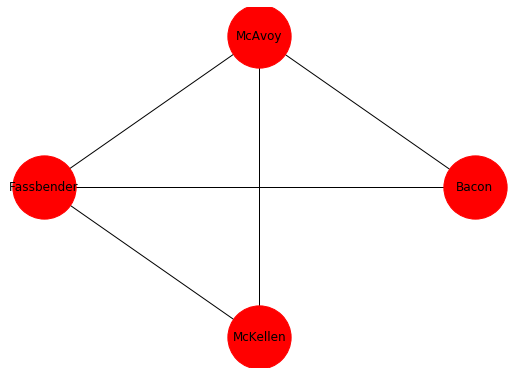

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

g=nx.Graph()
g.add_edge('Bacon','McAvoy') 
g.add_edge('Bacon','Fassbender')
g.add_edge('Fassbender','McAvoy')
g.add_edge('Fassbender','McKellen')
g.add_edge('McAvoy','McKellen')

pos = nx.shell_layout(g)
plt.figure(figsize=(7,5))
nx.draw(g, pos, node_size=4000, with_labels=True, node_color='r')
plt.show()

In [8]:
list(g.edges('Bacon'))

[('Bacon', 'McAvoy'), ('Bacon', 'Fassbender')]

## Scale free network
Stupanj vrha je broj bridova koji iz njega izlazi.

Distribucija stupnjeva je vjerojatnosna distribucija stupnjeva u cijelom grafu. To jest distribucija stupnja $P(k)$ je udio vrhova u grafu koji imaju stupanj $k$. Odnosno ako u grafu s $n$ vrhova ima $n_{k}$ vrhova stupnja k tada je $P(k)=\frac{n_{k}}{n}$

Za graf kažemo da je *scale-free* ako distribucija stupnjeva zadovoljava *power law* odnosno oblika je $P(k)=\alpha x^{-k}$

Promotrimo model koji generira *scale-free* graf.

## Barabasi-Albert model

Krećemo s grafom od $m_{0}$ čvorova koji mogu biti proizvoljno povezani.
* **Rast**: u svakom koraku dodajemo novi vrh koji povežemo s $m$ vrhova koji su već u grafu
* **Preferential attachment**: vjerojatnost da se novi vrh poveže s vrhom $i$ je $\pi(k_{i})=\frac{k_{i}}{\sum k_{i}}$ gdje je $k_{i}$ stupanj vrha i.


In [134]:
import numpy as np

def display_graph(G):
    pos=nx.circular_layout(G)
    n=G.number_of_nodes()
    boje=['g' for k in range(n-1)]
    boje.append('r')
    g=G.subgraph(np.arange(n-1))
    node_pr=node_prob(g)
    deg_cent=nx.degree_centrality(g)
    node_size=[2500*v for v in deg_cent.values()]
    node_size.append(1000)
    nx.draw(G,pos,node_color=boje,edge_color='black',node_size=node_size)
    
    labels={}
    for k in range(n-1):
        labels[k]=f'{node_pr[k]:.2f}'
    labels[n-1]='novi'    
    nx.draw_networkx_labels(G,pos,labels)
    nx.draw_networkx_edges(G,pos,edgelist=list(G.edges(i)),edge_color='r')
    
    return
   
    
def node_prob(G):
    degrees=np.array(nx.degree(G))[:,1]
    l=2*len(G.edges())
    node_pr=degrees/l
    
    return node_pr


def add_node(G,i,m):
    node_pr=node_prob(G)
    cumulative_node_prob=[]
    it=0
    for p in node_pr:
        cumulative_node_prob.append(it+p)
        it=it+p

    G.add_node(i)
   
    num_edges_added=0
    selected_nodes=[]
    #new_edges=[]

    while(num_edges_added<m):
        node_it=0
        u=np.random.uniform(0,1)
        while(u>cumulative_node_prob[node_it]):
            node_it+=1

        selected_node=node_it
        
        if selected_node in selected_nodes:
            continue
        
        selected_nodes.append(selected_node)

        G.add_edge(i,selected_node)
        num_edges_added+=1
        #new_edges.append((i,selected_node))
    
    return 

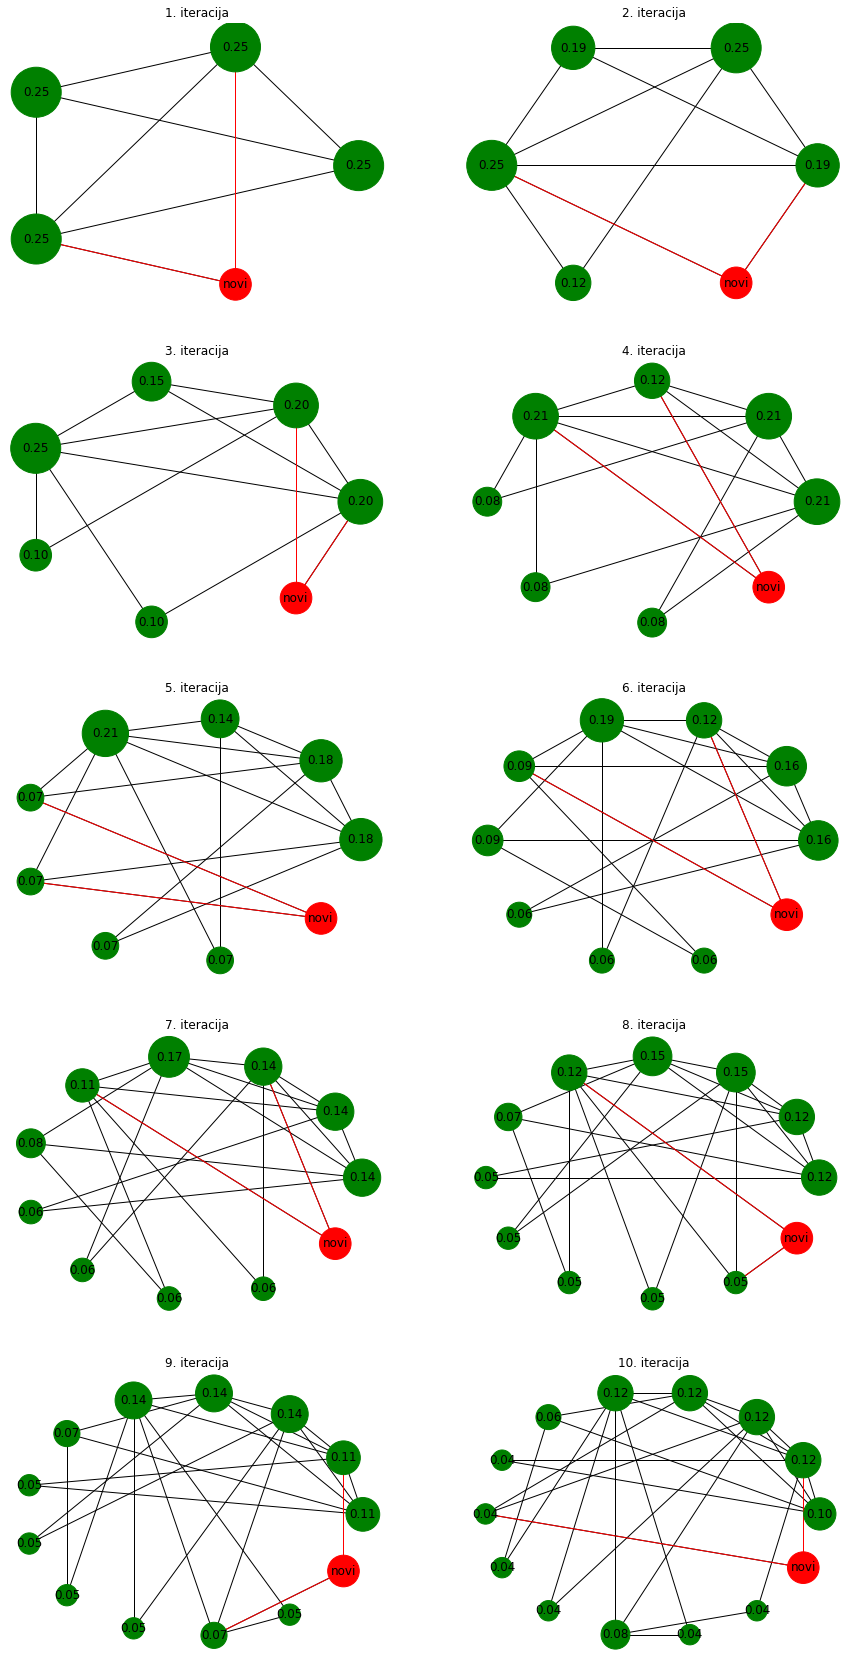

In [140]:

plt.rcParams['figure.figsize'] = [15,30]
m0=4
m=2
n=14

g=nx.complete_graph(m0)
for i in range(m0,n):
    add_node(g,i,m)
    plt.subplot(5,2,i-3)
    plt.title(f'{i-3}. iteracija')
    display_graph(g)

plt.show()
      

In [102]:
def plot_deg_dist(G,m,b):
    all_degrees=np.array(nx.degree(G))[:,1]
    different_degrees=np.array(list(set(all_degrees)))
    
    max=different_degrees.max()
    min=different_degrees.min()
    l=len(all_degrees)
        
    counts=np.bincount(all_degrees)
    no_zero_counts=counts[np.nonzero(counts)]
    prob_of_degrees=no_zero_counts/l
            
    x=np.arange(min,max+1)
    c=2*m*m
    y=c*1/x**3
    
    xn=x[y>=1/l]
    yn=y[y>=1/l]

    plt.loglog(different_degrees,prob_of_degrees,'ro',basex=10,basey=10)
    plt.plot(xn,yn,'--c')
    plt.xlabel('k')
    plt.ylabel('pk')
    plt.title(f'Distribucija stupnjeva nakon {b} koraka')
    plt.show()

In [100]:
def plot_degree_dynamics(G,t,stupnjevi_0,stupnjevi_100,stupnjevi_1000,stupnjevi_5000):
    x0=np.arange(t+1)
    x100=np.arange(100,t+1)
    x1000=np.arange(1000,t+1)
    x5000=np.arange(5000,t+1)

    x=np.arange(G.number_of_nodes())
    y=4*x**(1/2)
    
    plt.loglog(x0,stupnjevi_0,'red',basex=10,basey=10)
    plt.loglog(x100,stupnjevi_100,'blue',basex=10,basey=10)
    plt.loglog(x1000,stupnjevi_1000,'green',basex=10,basey=10)
    plt.loglog(x5000,stupnjevi_5000,'black',basex=10,basey=10)
    plt.plot(x,y,'--c')
    plt.xlabel('t')
    plt.ylabel('k(t)')
    plt.title('Stupnjevi vrhova dodanih u trenutcima 0,100,1000,5000')
    plt.show()

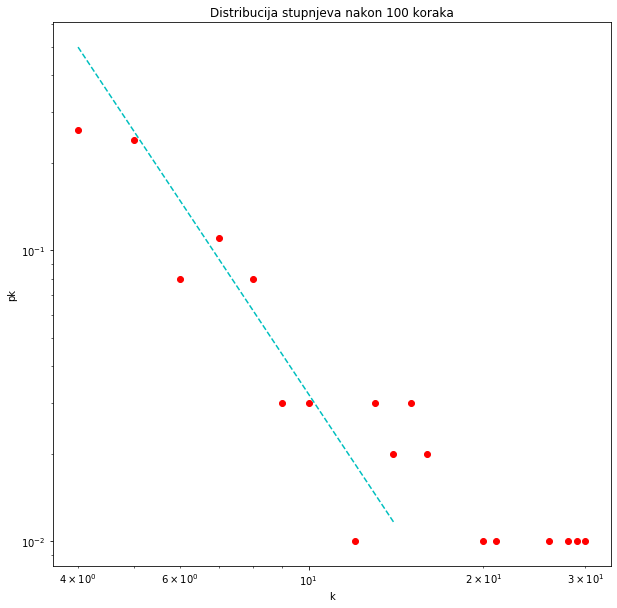

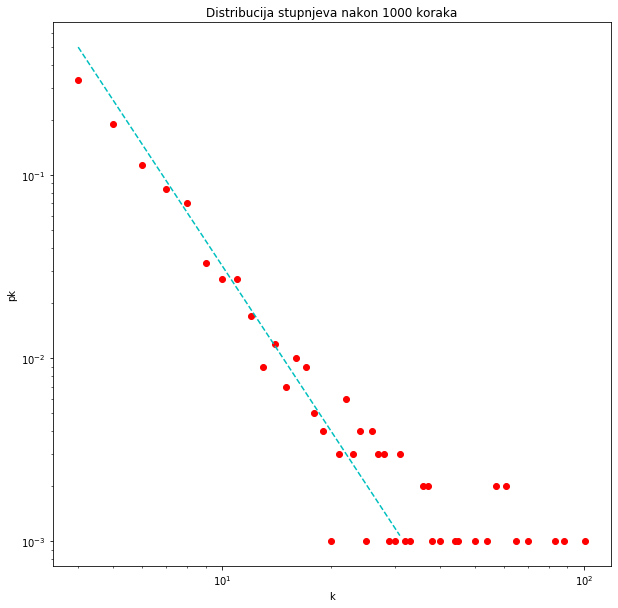

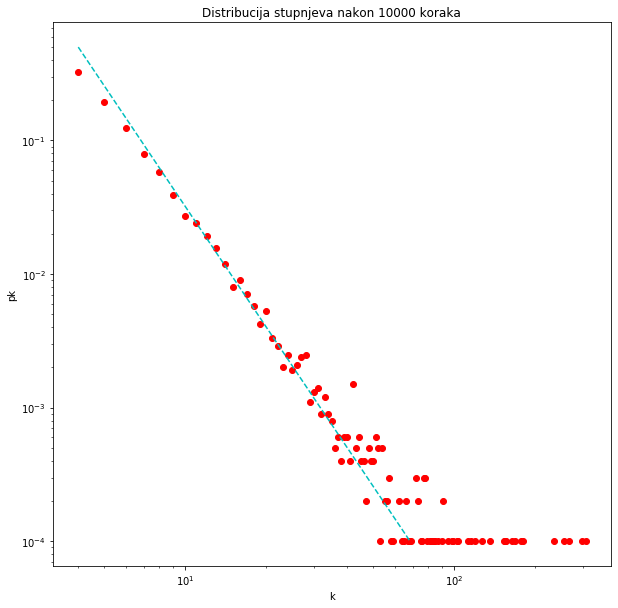

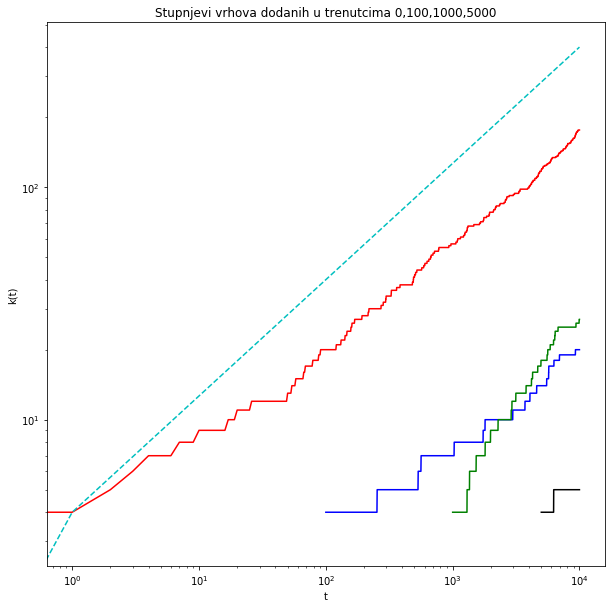

CPU times: user 6min 29s, sys: 944 ms, total: 6min 30s
Wall time: 6min 38s


In [141]:
%%time
plt.rcParams['figure.figsize'] = [10,10]
n=10000
m0=4
m=4
G=nx.complete_graph(m0)
stupnjevi_0=[]
stupnjevi_100=[]
stupnjevi_1000=[]
stupnjevi_5000=[]
stupnjevi_0.append(m0-1)

for i in range(m0,n):
    t=i-m0+1
    add_node(G,i,m)
    if t>=100:
        stupnjevi_100.append(G.degree(103))
    if t>=1000:
        stupnjevi_1000.append(G.degree(1003))
    if t>=5000:
        stupnjevi_5000.append(G.degree(5003))
    stupnjevi_0.append(G.degree(0))
    if(i==99 or i==999 or i==9999):
        plot_deg_dist(G,m,i+1)

plot_degree_dynamics(G,t,stupnjevi_0,stupnjevi_100,stupnjevi_1000,stupnjevi_5000)

In [139]:
def display_graph2(G):
    pos = nx.spring_layout(G)
    betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    node_color = [20000.0 * G.degree(v) for v in G]
    node_size =  [v * 10000 for v in betCent.values()]
    plt.figure(figsize=(20,20))
    nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
    plt.axis('off')
    return

In [142]:
display_graph2(G)

KeyboardInterrupt: 

In [108]:
nx.average_clustering(G)

0.006349660559368202

In [109]:
nx.average_shortest_path_length(G)

3.889227502750275

Pratimo promjenu stupnja vrha $i$ kroz vrijeme.

$\frac{\partial k_{i}}{\partial t}\propto m \frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$

gdje je $t$ vremenski korak a N ukupan broj čvorova u grafu. Naime u svakom koraku dodajemo $m$ novih bridova a svaki ima vjerojatnost $\frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$ da se poveže s $i$. ...

# test

In [68]:
%%time 
node_pr=node_prob(G)

CPU times: user 65.7 ms, sys: 3.97 ms, total: 69.7 ms
Wall time: 82.9 ms


In [72]:
%%time
cumulative_node_prob=[]
it=0
for p in node_pr:
    cumulative_node_prob.append(it+p)
    it=it+p
node_it=0
u=np.random.uniform(0,1)        
while(u>cumulative_node_prob[node_it]):
    node_it+=1

selected_node=node_it
print(selected_node)

4475
CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 23.3 ms


In [89]:
%%time
g=nx.complete_graph(4)
for i in range(4,5000):
    add_node(g,i,4)
    if i%100==0: print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
CPU times: user 1min 20s, sys: 59.9 ms, total: 1min 20s
Wall time: 1min 20s


In [80]:
G.number_of_nodes()

10000

In [81]:
%%time
add_node(G,10000,4)

CPU times: user 93.4 ms, sys: 4 ms, total: 97.5 ms
Wall time: 110 ms
